<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/litneet64/Lab-4/litneet64_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 4: Function Aproximation**
**Pablo Aravena**

# **Abstract**

 In this report, we are tasked with approximating a piecewise linear function with a $L^2$ projection over a $1D$ mesh, for which we use a modified version of the Assemble System Algorithm found on the lecture notes, along with some of the other necessary auxiliary functions for it.

# **About the code**

In [0]:
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Pablo Aravena (pjan2@kth.se)

# Based on the template by Johan Hoffman (jhoffman@kth.se)
# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from math import sin

# **Introduction**

The $L^2$ projection $Pf$ of $f \in L^2(I)$ onto a space of linear functions $V_{h}^1$ can be expressed as:

\begin{equation*}
     Pf (x) = \sum_{j = 0}^{m+1} \alpha_j \phi_j (x) 
\end{equation*}

Resulting in a matrix equation $A\alpha = b$, where $A$ is the $\textit{mass matrix}$, $\alpha$ the $\textit{solution vector}$ and $b$ is the $\textit{load vector}$, with $A$ given by $(9.14, 9.15, 9.16)$:

\begin{equation*}
     a_{ii} = \frac{h_i+ h_{i+1}}{3}\\
     a_{i, i+1} = \frac{h_{i+1}}{6}\\
     a_{i, i-1} = \frac{h_i}{6}
\end{equation*}

$h_i$ being the length of the mesh $i$:

\begin{equation*}
h_i = x_i - x_{i-1}
\end{equation*}

$x_i$ the node point from that $i^{th}$ subinterval, and $b$ being given by $(9.17)$:

\begin{equation*}
     b_i = (f, \phi_i) = \int_{I} f(x) \phi_i (x) dx
\end{equation*}

Where $\phi_i$ is:

\begin{equation*}
     \phi_i(x) = \begin{cases} 
                      \frac{x - x_{k-1}}{h_k} & x \in I_k \\
                      \frac{x_{k+1} - x}{h_{k+1}} & x \in I_{k+1} \\
                      0 & \textit{any other case}
                  \end{cases}
\end{equation*}

With the piece definitions being the local linear Lagrange shape functions for the Interval $I_k$ and $I_{k+1}$.

Knowing this, we can then proceed with the implementation of the $\textit{Assemble System Algorithm}$, which will create the linear system $A\alpha = b$ given a function $f$ defined over a mesh ($I$), and then solve it to get the function approximations stored in the solution vector $\alpha$.

# **Methods**

#### Assemble System and other auxiliary functions
Implemented partly following lecture notes as seen in $Algorithm$ $9.2$. Following the advice given on the same section, we iterate over the subintervals $I_k$ and calculate the integrals for the local matrices and vectors subinterval by subinterval, and then we add the results to the global ones. As we are on $1D$ (that is, $q = 1$), the local matrix has a dimension of $(2x2)$ and the vector $(2x1)$.

In [0]:
# auxiliary function to calculate the integral of given matrix on a subinterval
def int_matrix(k, i, j, mesh):
    
    # calculate length of subinterval
    h = abs(mesh[k] - mesh[k-1])
    
    # get the already known integral values
    if i == j:
        return h / 3
    elif (i + 1) == j or (i - 1) == j:
        return h / 6
    
    return 0
    
    
# auxiliary function to calculate the integral of given vector on a subinterval
def int_vector(func, k, i, mesh):
    # calculate length of subinterval
    h = abs(mesh[k] - mesh[k-1])
    
    # lagrange polynomials multiplied by the functions
    lagr_f = {0: lambda x: func(x) * (mesh[k+1] - x) / h,
              1: lambda x: func(x) * (x - mesh[k]) / h
              }
        
    # calculate and return corresponding integral for subinterval
    return integrate.quad(lagr_f[i], mesh[k], mesh[k+1])[0]
    

def assembleSystem(func, mesh):
    # get num of subintervals, create global A matrix and b vector for the system
    n = len(mesh)
    A = np.zeros((n, n))
    b = np.zeros((n))
        
    # should be 1 for the dimesion we are using it for
    q = 1
    
    # go for every subinterval
    for k in range(n-1):
        # local A matrix of (q+1)x(q+1) and b vector of (q+1)
        loc_A = np.zeros((q+1, q+1))
        loc_b = np.zeros((q+1))
        
        # integrate piece-by-piece of local matrix and vector for this subinterval
        for i in range(q + 1):
            loc_b[i] = int_vector(func, k, i, mesh)
            
            for j in range(q + 1):
                loc_A[i,j] = int_matrix(k, i, j, mesh)
        
        # add local b vector to the global one
        b[k] += loc_b[0]
        b[k+1] += loc_b[1]
        
        # add local A matrix to the global one
        A[k, k] += loc_A[0, 0]
        A[k, k+1] += loc_A[0, 1]
        A[k+1, k] += loc_A[1, 0]
        A[k+1, k+1] += loc_A[1, 1]
        
    # get the solution vector alpha
    alpha = np.linalg.solve(A, b)
    
    return alpha



#### Tester Method

To test the accuracy we used the function $Sin^2(x) + Sin(x) + x$, with the mesh made out of $50$ points between $-10$ and $10$. For the testing of the error convergence a similar approach was used, but instead of a fixed quantity of points (previously $50$) we increased them by steps of $10$ until reaching $1000$.

Both tests show a plot as to visualize the phenomena a little better than it would be watching the raw data.

In [0]:
# method to plot both functions against the other to compare them visually
def showBoth():
    x_lab = "x axis"
    y_lab = "y axis"
    title = "Both Functions plotted against each other"
    
    func = lambda x: sin(x)**2 + sin(x) + x
    mesh = np.linspace(-10, 10, 50)
    
    # real function evaluated in the mesh
    real_func_points = list(map(func, mesh))
    
    # our approx function evaluated in the mesh
    our_func_points = assembleSystem(func, mesh)
    
    
    # plot for real function
    plt.plot(mesh, real_func_points, ",--r", linewidth = 2)
    
    # plot for our approximation function
    plt.plot(mesh, our_func_points, ",--b", linewidth = 2)
    
    
    plt.legend(["sin(x)^2 + sin(x) + x", "approx. function"], fontsize = 20)
    
    # call the general plotting stub down below
    generalPlot(title, x_lab, y_lab)
    
    
# method to plot the convergence rate as the number of points increase
def showErrorConvergence():
    x_lab = "Number of Points"
    y_lab = "Error"
    title = "Convergence as the Number of Points increase"
    
    # test function
    func = lambda x: sin(x)**2 + sin(x) + x
    
    # avg error array
    avg_error = []
    
    # increase number of points with steps of 10 until 1001
    for i in range(10, 1001, 10):
        mesh = np.linspace(-10, 10, i)
        
        # real function evaluated in the mesh
        real_func_points = list(map(func, mesh))
    
        # our approx function evaluated in the mesh
        our_func_points = assembleSystem(func, mesh)
    
        # both points 
        both = zip(real_func_points, our_func_points)
    
        # all the errors for this number of points used
        errors = list(map(lambda tup: abs(tup[0] - tup[1]), both))
        
        # get the average error and add it to our list
        a_err = sum(errors) / len(errors)
        avg_error.append(a_err)
    
    
    # plot for our average error function
    plt.plot(list(range(10, 1001, 10)), avg_error, ",--b", linewidth = 2)
    
    plt.legend(["average error function"], fontsize = 20)
    
    
    # call the general plotting stub down below
    generalPlot(title, x_lab, y_lab)

# settings for the plot that both methods use
def generalPlot(g_title, x_label, y_label):
    # setup size of figure (width, height)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 30
    fig_size[1] = 20
    plt.rcParams["figure.figsize"] = fig_size
        
    # setup labels for graph and show it
    plt.title(g_title, fontsize = 30)
    plt.ylabel(y_label, fontsize = 20)
    plt.xlabel(x_label, fontsize = 20)
                        
    plt.show()

    

# **Results**

Here we are plotting both functions for the same set of $x$ points. We can see that near $-10$ the error get's much bigger than on the other sections of the function, where it's way smoother and almost identical to the original one.

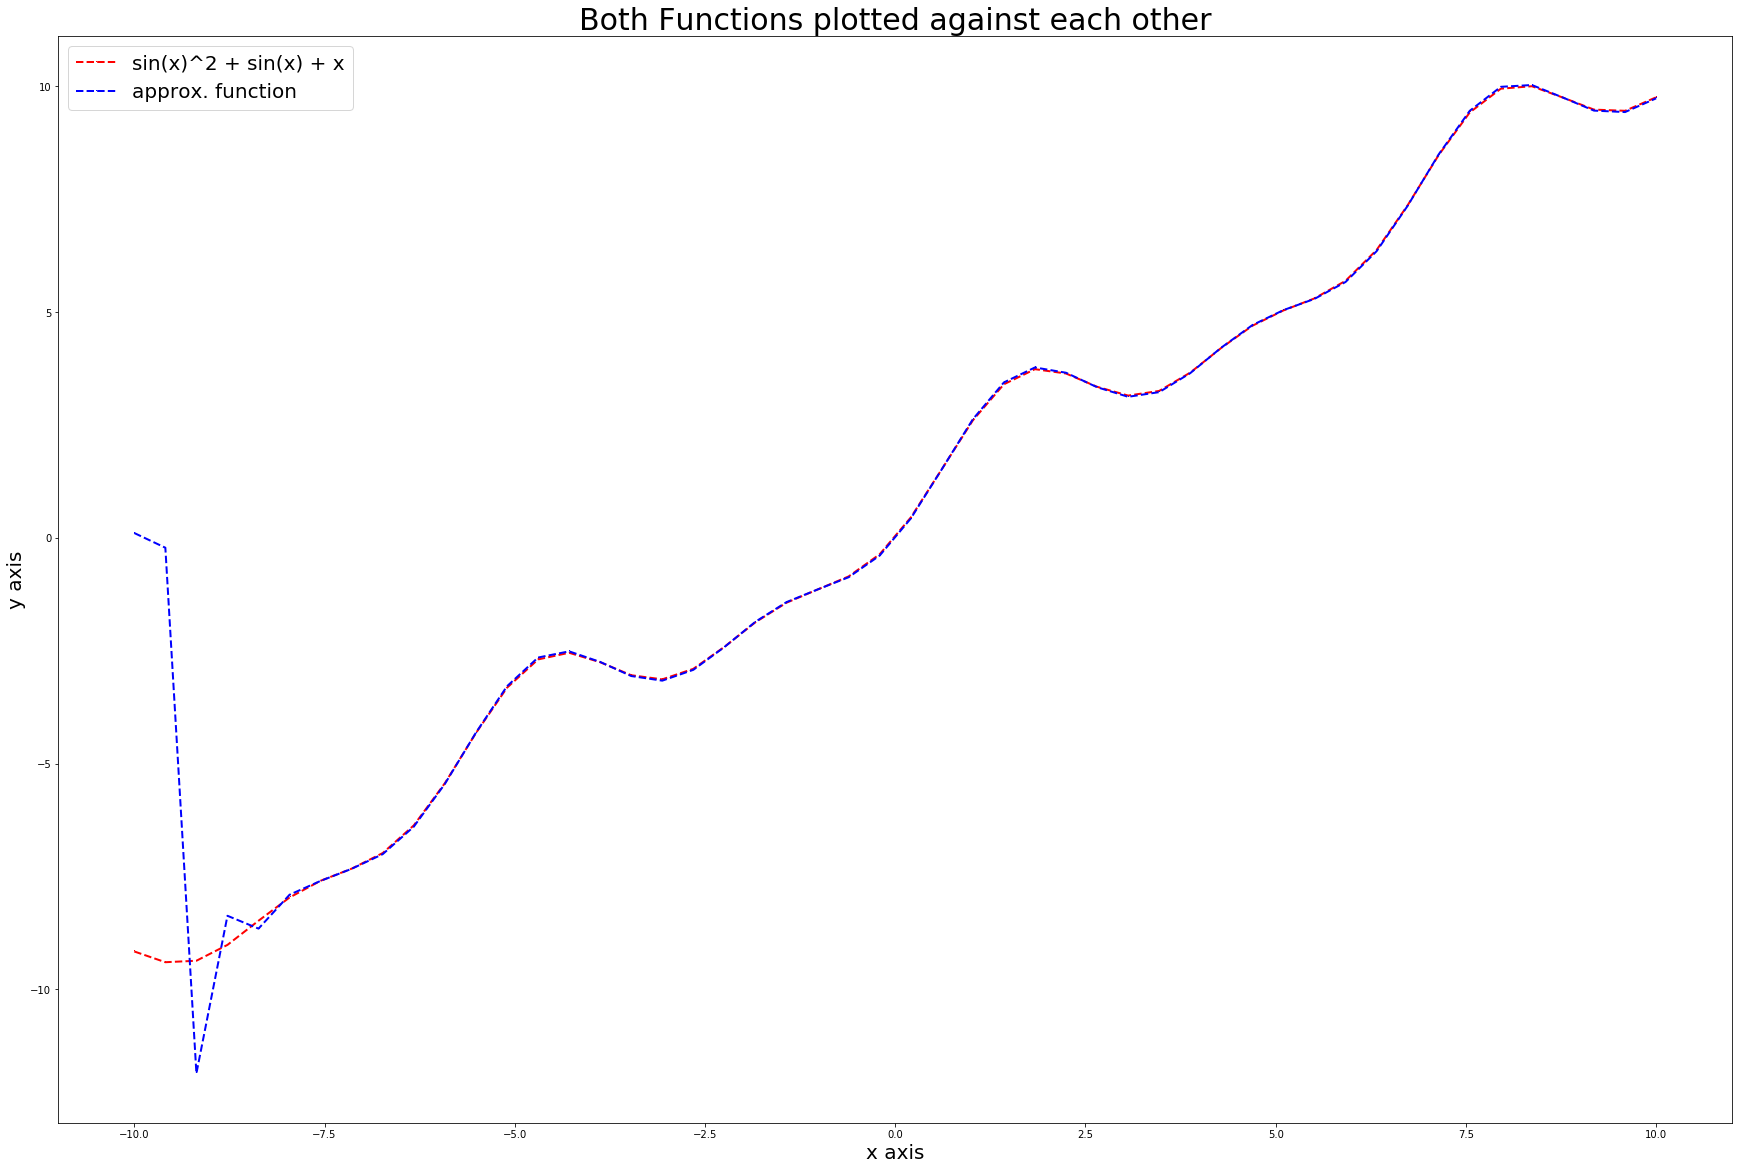

In [6]:
showBoth()

This plot is for the average error function for every point. That is, we take the real values and substract them from the approximation given ones and store them on a list ($E_n$, where $n$ is the variable number of points), after that we average all the errors from $E_n$ and that becomes $E_{avg}(n) = E_n$. It ends up being as this:

\begin{equation*}
    E_k = \{err: |x - y|, \text{$y$ $\in$ $f_{real}$ and $x$ $\in$ $f_{approx}$} \}\\
    E_{avg} = \{E_{avg}n:  \sum_{\text{$e$ $\in$ $E_n$}}^n e \cdot \frac{1}{n} \}
\end{equation*}


We can see that the average error tends to $0$ as the quantity of points increases.

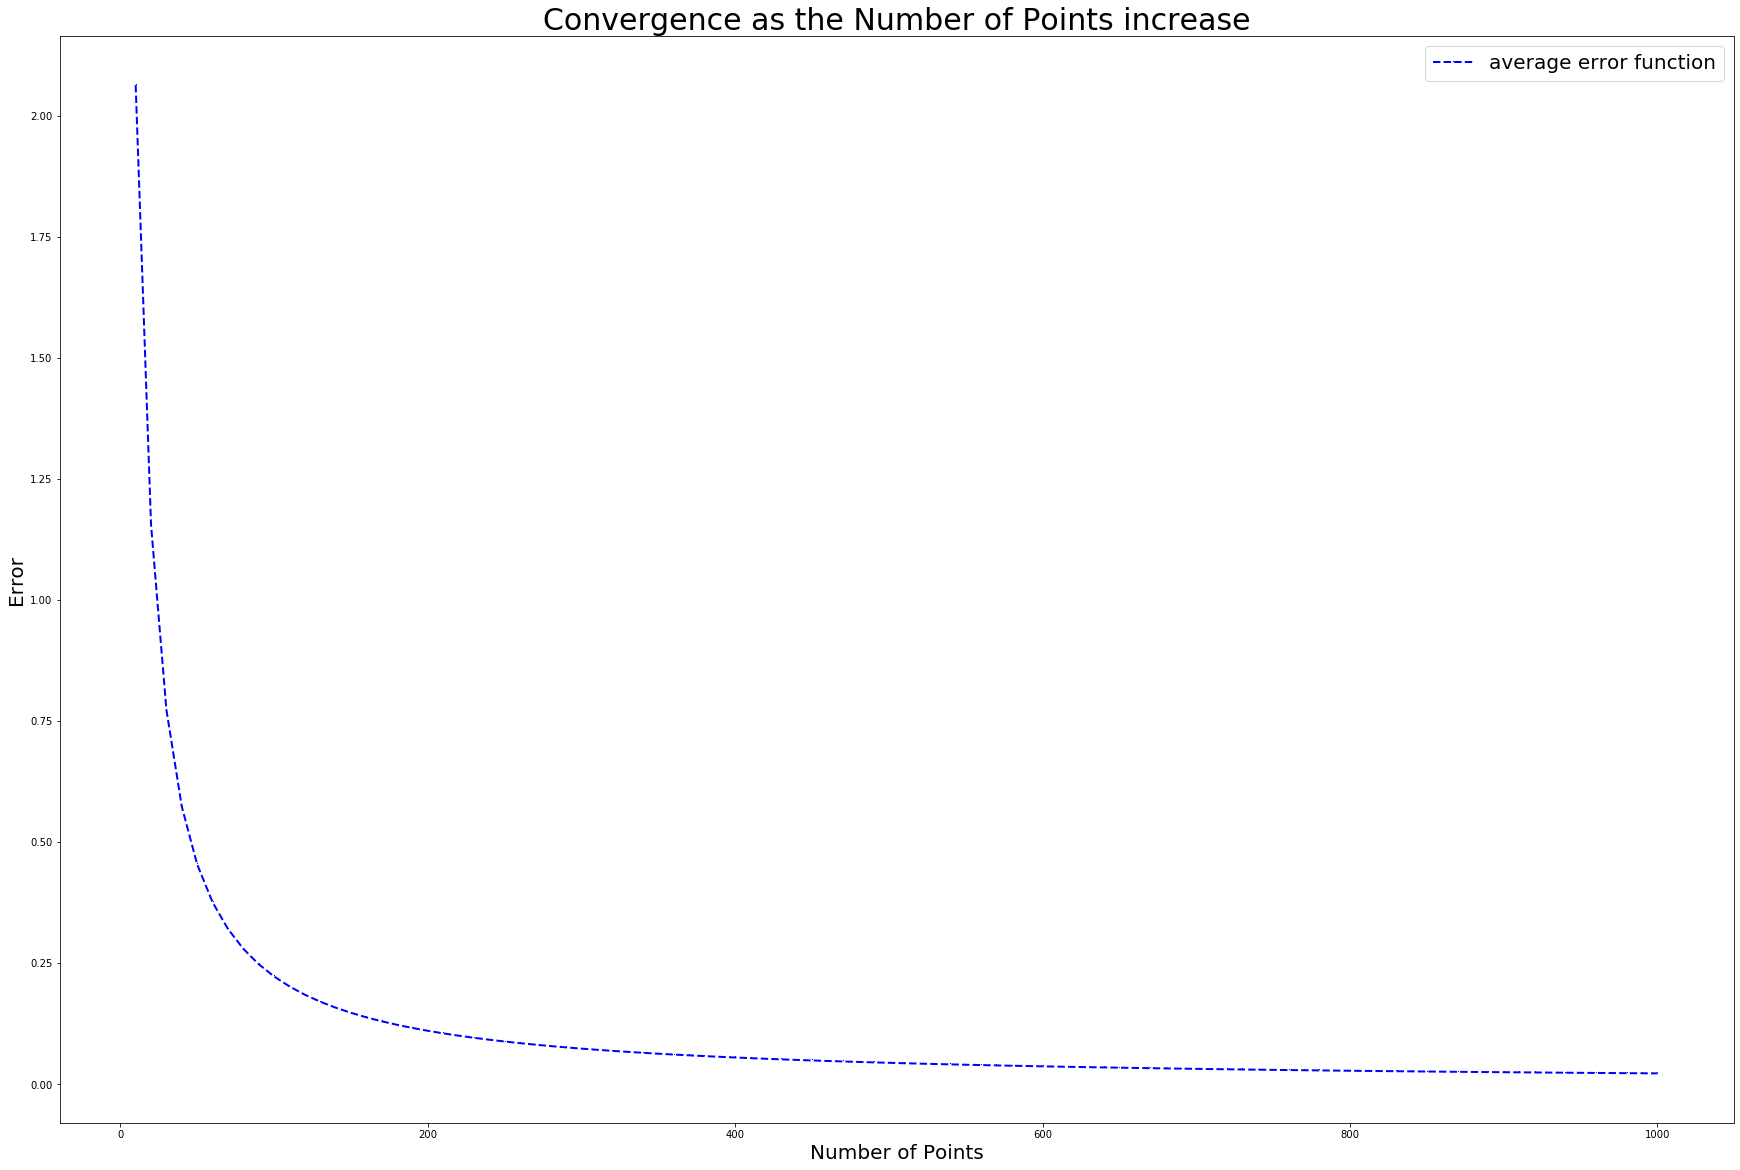

In [0]:
showErrorConvergence()

# **Discussion**

 This time the method to implement was only $1$, but still needed much more theory than other labs, still, proved to be an interesting task to make, as function approximation is a very useful tool.